In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

1.10.1 0.11.2


In [2]:
# 加载CIFAR-10数据集，如果本地没有则自动下载
dst = datasets.LFWPeople("/home/raoxy/data", download=True)

Files already downloaded and verified


In [3]:
# 定义一个转换序列，包括缩放、裁剪、转换为张量等操作
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

# 定义一个函数，用于将张量转换为PIL图像
tt = transforms.ToPILImage()

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

Running on cuda


In [4]:
# 定义一个函数，用于将标签转换为one-hot编码的张量
def label_to_onehot(target, num_classes=10):
    # 在第一个维度上增加一个维度，使得target的形状为(N, 1)
    target = torch.unsqueeze(target, 1)
    # 创建一个全零的张量，形状为(N, num_classes)，设备与target相同
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    # 在第二个维度上根据target的值将onehot_target的对应位置设为1
    onehot_target.scatter_(1, target, 1)
    # 返回onehot_target
    return onehot_target

# 定义一个函数，用于计算one-hot编码的标签和预测值之间的交叉熵损失
def cross_entropy_for_onehot(pred, target):
    # 对预测值进行log_softmax操作，然后与目标值相乘，再求和，最后求平均
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

# LeNet

In [5]:
# 定义一个类，继承自nn.Module，表示LeNet模型
class LeNet(nn.Module):
    # 定义模型的构造函数
    def __init__(self):
        # 调用父类的构造函数
        super(LeNet, self).__init__()
        # 定义激活函数为Sigmoid
        act = nn.Sigmoid
        # 定义模型的卷积部分，包括四个卷积层和两个池化层，以及Sigmoid激活函数
        self.body = nn.Sequential(
            # 第一个卷积层，输入通道为3，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            # 第一个激活层，使用Sigmoid函数
            act(),
            # 第二个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为2
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            # 第二个激活层，使用Sigmoid函数
            act(),
            # 第三个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第三个激活层，使用Sigmoid函数
            act(),
            # 第四个卷积层，输入通道为12，输出通道为12，卷积核大小为5，填充为2，步长为1
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            # 第四个激活层，使用Sigmoid函数
            act(),
        )
        # 定义模型的全连接部分，包括一个线性层
        self.fc = nn.Sequential(
            # 第一个线性层，输入特征为768，输出特征为10，表示10个类别
            nn.Linear(768, 5749),
            # 注释掉了第二个激活层和第二个线性层，可能是为了简化模型
            #act(),
            #nn.Linear(256, 10)
        )
        
    # 定义模型的前向传播函数
    def forward(self, x):
        # 将输入数据通过卷积部分，得到输出
        out = self.body(x)
        # 将输出展平为一维向量，形状为(N, 768)，其中N是批量大小
        feature = out.view(out.size(0), -1)
        # 打印特征的形状，用于调试
        #print(feature.size())
        # 将特征通过全连接部分，得到最终的输出
        out = self.fc(feature)
        # 返回输出和特征
        return out, feature
    

In [6]:
# class LeNet(nn.Module):
#     # 定义模型的构造函数
#     def __init__(self):
#         # 调用父类的构造函数
#         super(LeNet, self).__init__()
#         # 定义激活函数为Sigmoid
#         act = nn.Sigmoid
#         # 定义模型的卷积部分，包括四个卷积层和两个池化层，以及Sigmoid激活函数
#         self.body = nn.Sequential(
#             # 第一个卷积层，输入通道为3，输出通道为12，卷积核大小为5，填充为2，步长为2
#             nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
#             # 第一个激活层，使用Sigmoid函数
#             act(),
#             # 第二个卷积层，输入通道为12，输出通道为24，卷积核大小为5，填充为2，步长为2
#             nn.Conv2d(12, 24, kernel_size=5, padding=5//2, stride=2),
#             # 第二个激活层，使用Sigmoid函数
#             act(),
#             # 第三个卷积层，输入通道为24，输出通道为48，卷积核大小为5，填充为2，步长为2
#             nn.Conv2d(24, 48, kernel_size=5, padding=5//2, stride=2),
#             # 第三个激活层，使用Sigmoid函数
#             act(),
#             # 第四个卷积层，输入通道为48，输出通道为96，卷积核大小为5，填充为2，步长为2
#             nn.Conv2d(48, 96, kernel_size=5, padding=5//2, stride=2),
#             # 第四个激活层，使用Sigmoid函数
#             act(),
#         )
#         # 定义模型的全连接部分，包括一个线性层
#         self.fc = nn.Sequential(
#             # 第一个线性层，输入特征为96*4*4，输出特征为5749，表示5749个类别
#             nn.Linear(24576, 5749),
#             # 注释掉了第二个激活层和第二个线性层，可能是为了简化模型
#             #act(),
#             #nn.Linear(256, 10)
#         )
        
#     # 定义模型的前向传播函数
#     def forward(self, x):
#         # 将输入数据通过卷积部分，得到输出
#         out = self.body(x)
#         # 将输出展平为一维向量，形状为(N, 96*4*4)，其中N是批量大小
#         feature = out.view(out.size(0), -1)
#         # 打印特征的形状，用于调试
#         #print(feature.size())
#         # 将特征通过全连接部分，得到最终的输出
#         out = self.fc(feature)
#         # 返回输出和特征
#         return out, feature

In [7]:
# 创建一个LeNet模型的实例，并将其移动到设备上，可以是CPU或GPU
net = LeNet().to(device)
net

LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=5749, bias=True)
  )
)

In [8]:
# 定义一个函数，用于初始化模型的权重和偏置
def weights_init(m):
    # 如果模型有权重属性，就将其均匀分布在[-0.5, 0.5]之间
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    # 如果模型有偏置属性，也将其均匀分布在[-0.5, 0.5]之间
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
    
# 调用weights_init函数，对模型的参数进行初始化
net.apply(weights_init)
# 定义损失函数为one-hot编码的交叉熵损失
criterion = cross_entropy_for_onehot

# 图像索引

In [9]:
# 定义一个图像索引，表示要显示的图像在数据集中的位置
img_index = 0

GT label is 12. 
Onehot label is 12.


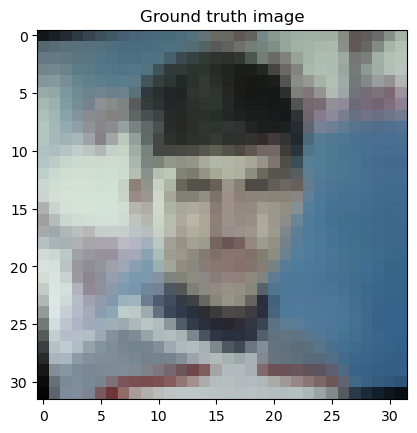

In [10]:
# 从数据集中获取图像，并使用之前定义的转换序列处理图像
gt_data = tp(dst[img_index][0]).to(device)
# 将图像的形状调整为(1, 3, 32, 32)，表示批量大小为1，通道数为3，高度和宽度为32
gt_data = gt_data.view(1, *gt_data.size())
# 从数据集中获取图像的标签，并转换为长整型张量
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
# 将标签的形状调整为(1,)，表示批量大小为1
gt_label = gt_label.view(1, )
# 将标签转换为one-hot编码的张量，形状为(1, 10)，表示批量大小为1，类别数为10
gt_onehot_label = label_to_onehot(gt_label, num_classes=5749)

# 设置图像的梯度属性为True，表示可以对图像进行梯度计算
gt_data.requires_grad = True

# 将图像从张量转换为PIL图像，并使用matplotlib显示图像
plt.imshow(tt(gt_data[0].cpu()))
# 设置图像的标题为"Ground truth image"
plt.title("Ground truth image")
# 打印图像的标签和one-hot编码的标签
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

In [11]:
# 计算输出和特征向量相对于输入的导数的范数与特征向量的范数的比值，即||dr/dX||/||r||
out,feature_fc1_graph = net(gt_data) # 通过网络得到输出和特征向量
deviation_f1_target = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储目标梯度
deviation_f1_x_norm = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储导数的范数
for f in range(deviation_f1_x_norm.size(1)): # 对于每个特征向量的维度
    deviation_f1_target[:,f] = 1 # 将目标梯度的对应位置设为1
    feature_fc1_graph.backward(deviation_f1_target, retain_graph=True) # 对特征向量进行反向传播，计算梯度
    deviation_f1_x = gt_data.grad.data # 获取输入的梯度
    deviation_f1_x_norm[:,f] = torch.norm(deviation_f1_x.view(deviation_f1_x.size(0), -1), dim=1)/(feature_fc1_graph.data[:,f]) # 计算梯度的范数与特征向量的比值
    net.zero_grad() # 清零网络的梯度
    gt_data.grad.data.zero_() # 清零输入的梯度
    deviation_f1_target[:,f] = 0 # 将目标梯度的对应位置设为0

In [12]:
# 根据最小的||dr_i/dX||/||r_i||来剪枝特征向量
deviation_f1_x_norm_sum = deviation_f1_x_norm.sum(axis=0) # 对每个维度求和
thresh = np.percentile(deviation_f1_x_norm_sum.flatten().cpu().numpy(), 1) # 根据百分位数确定阈值
mask = np.where(abs(deviation_f1_x_norm_sum.cpu()) < thresh, 0, 1).astype(np.float32) # 根据阈值生成掩码，小于阈值的为0，大于阈值的为1
print(sum(mask)) # 打印掩码的和，即保留的特征向量的数量

760.0


In [13]:
y = criterion(out, gt_onehot_label) # 计算输出和标签之间的损失
dy_dx = torch.autograd.grad(y, net.parameters()) # 计算损失对网络参数的梯度

In [14]:
# 与其他客户端共享梯度
original_dy_dx = list((_.detach().clone() for _ in dy_dx)) # 复制梯度

In [15]:
# original_dy_dx[-2] = original_dy_dx[-2] * torch.Tensor(mask).to(device)# 将梯度乘以掩码，实现剪枝

In [16]:
# model compression（GC）
for i in range(len(original_dy_dx)):
    grad_tensor = original_dy_dx[i].cpu().numpy() # 将梯度转换为numpy数组
    flattened_weights = np.abs(grad_tensor.flatten()) # 将梯度展平并取绝对值
    # Generate the pruning threshold according to 'prune by percentage'. (Your code: 1 Line) 
    thresh = np.percentile(flattened_weights, 10) # 根据百分位数确定剪枝阈值
    grad_tensor = np.where(abs(grad_tensor) < thresh, 0, grad_tensor) # 根据阈值将梯度置零
    original_dy_dx[i] = torch.Tensor(grad_tensor).to(device) # 将梯度转换为张量

# 绘制导数的范数和特征向量的曲线

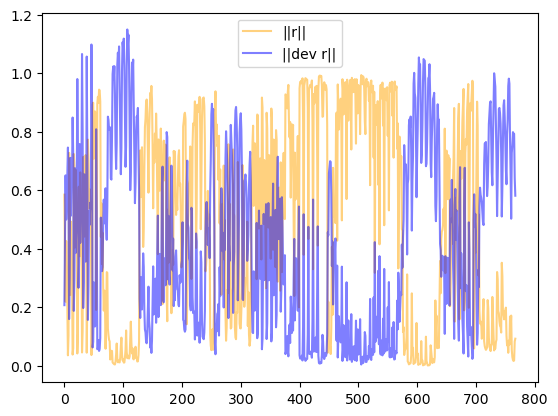

In [17]:
plt.figure() # 创建一个图形
plt.plot(feature_fc1_graph.cpu().detach().numpy().flatten(),alpha=0.5,color="orange", label='||r||') # 绘制特征向量的曲线
plt.plot(deviation_f1_x_norm_sum.cpu().numpy(),alpha=0.5,color="blue", label='||dev r||') # 绘制导数的范数的曲线
plt.legend() # 显示图例
plt.show() # 显示图'形

Dummy label is 4867.


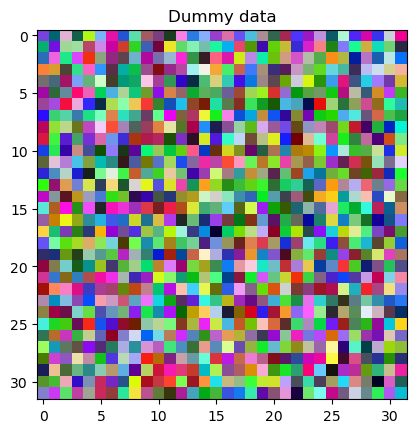

In [18]:
# 生成一些随机的数据和标签，形状与真实的数据和标签相同
dummy_data_init = torch.randn(gt_data.size()) # 使用torch.randn()函数[^1^][1]生成一个服从标准正态分布的张量
dummy_label_init = torch.randn(gt_onehot_label.size()) # 同上

# 将随机的数据和标签转换为张量，并移动到设备上，可以是CPU或GPU
dummy_data = torch.Tensor(dummy_data_init).to(device).requires_grad_(True) # 使用torch.Tensor()函数将numpy数组转换为张量，并设置requires_grad属性为True，表示可以对数据进行梯度计算
dummy_label = torch.Tensor(dummy_label_init).to(device).requires_grad_(True) # 同上

# 使用plt.imshow()函数将数据的第一张图像显示出来，需要先将张量转换为numpy数组，并使用tt()函数将其转换为PIL图像
plt.imshow(tt(dummy_data[0].cpu())) # 使用cpu()函数将张量从GPU移动到CPU，否则无法转换为numpy数组
# 设置图像的标题为"Dummy data"
plt.title("Dummy data")
# 打印标签的最大值的索引，即虚拟的类别
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item()) # 使用torch.argmax()函数获取张量在指定维度上的最大值的索引，使用item()函数[^6^][6]获取张量中的元素值

In [19]:
# 定义一个LBFGS优化器，将虚拟的数据和标签作为需要优化的参数
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
# 注释掉了另一个优化器，SGD，可能是为了比较效果
#optimizer = torch.optim.SGD([dummy_data, dummy_label], lr=0.1, momentum=0.9 )

# 创建一个空列表，用于存储优化过程中的虚拟数据
history = []
# 定义一个变量，用于存储虚拟数据和真实数据之间的最小均方误差
MSE_min = 100
# 进行300次迭代优化
for iters in range(300):
    # 定义一个闭包函数，用于计算虚拟数据和标签的梯度差
    def closure():
        # 清零优化器的梯度
        optimizer.zero_grad()
        # 通过网络得到虚拟数据的预测和特征向量
        #out, [feature_fc1_graph, feature_fc2_graph, feature_fc3_graph] = net(gt_data)
        pred, f1 = net(dummy_data) 
        # 对虚拟标签进行softmax操作，得到one-hot编码的张量
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        # 计算预测和虚拟标签之间的损失，使用之前定义的交叉熵损失函数
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        # 计算损失对网络参数的梯度，创建计算图
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        # 初始化梯度差和梯度数量为0
        grad_diff = 0
        grad_count = 0
        
        # 设置一个计数器
        i = 0
        # 对于虚拟数据和真实数据的梯度，逐个计算它们的差的平方和
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            # 只计算前100个参数的梯度差，可能是为了节省计算资源
            if i <=100:
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            i += 1
        # 计算梯度差的平均值，乘以一个系数，可能是为了调整梯度的大小
        #grad_diff = grad_diff / grad_count * 1000
        
        # 计算特征向量和真实数据的差的平方和，可能是另一种计算梯度差的方法
        #grad_diff = ((feature_fc1_graph - f1) ** 2).sum()
        # 对梯度差进行反向传播，计算虚拟数据和标签的梯度
        grad_diff.backward()
        
        # 返回梯度差
        return grad_diff
    
    # 调用优化器的step()方法，使用闭包函数进行一步优化
    optimizer.step(closure)
    # 如果当前的均方误差小于之前的最小值，就更新最小值
    if MSE_min > (gt_data[0] - dummy_data[0]).pow(2).mean().item():
        MSE_min = (gt_data[0] - dummy_data[0]).pow(2).mean().item()
    # 每隔10次迭代，打印当前的迭代次数，梯度差，均方误差和最小均方误差
    if iters % 10 == 0: 
        current_loss = closure()
        print("{}, loss: {}, MSE: {}, MSE_min: {}".format(iters, current_loss.item(), (gt_data[0] - dummy_data[0]).pow(2).mean().item(), MSE_min))
    # 将当前的虚拟数据添加到历史列表中
    history.append(tt(dummy_data[0].cpu()))

0, loss: 390.57666015625, MSE: 2.183253526687622, MSE_min: 2.183253526687622
10, loss: 1.2279632091522217, MSE: 0.7196232080459595, MSE_min: 0.7196232080459595
20, loss: 0.2296188324689865, MSE: 0.3018014430999756, MSE_min: 0.3018014430999756
30, loss: 0.10893621295690536, MSE: 0.12090252339839935, MSE_min: 0.12090252339839935
40, loss: 0.08904954046010971, MSE: 0.05279957503080368, MSE_min: 0.05279957503080368
50, loss: 0.08500006794929504, MSE: 0.02887582778930664, MSE_min: 0.02887582778930664
60, loss: 0.08381237834692001, MSE: 0.01877189427614212, MSE_min: 0.01877189427614212
70, loss: 0.08330243080854416, MSE: 0.013694338500499725, MSE_min: 0.013694338500499725
80, loss: 0.08300945907831192, MSE: 0.010693970136344433, MSE_min: 0.010693970136344433
90, loss: 0.08289514482021332, MSE: 0.009485455229878426, MSE_min: 0.009485455229878426
100, loss: 0.08281972259283066, MSE: 0.008746523410081863, MSE_min: 0.008746523410081863
110, loss: 0.08277560025453568, MSE: 0.008337357081472874, M

# 画图

Dummy label is 12.


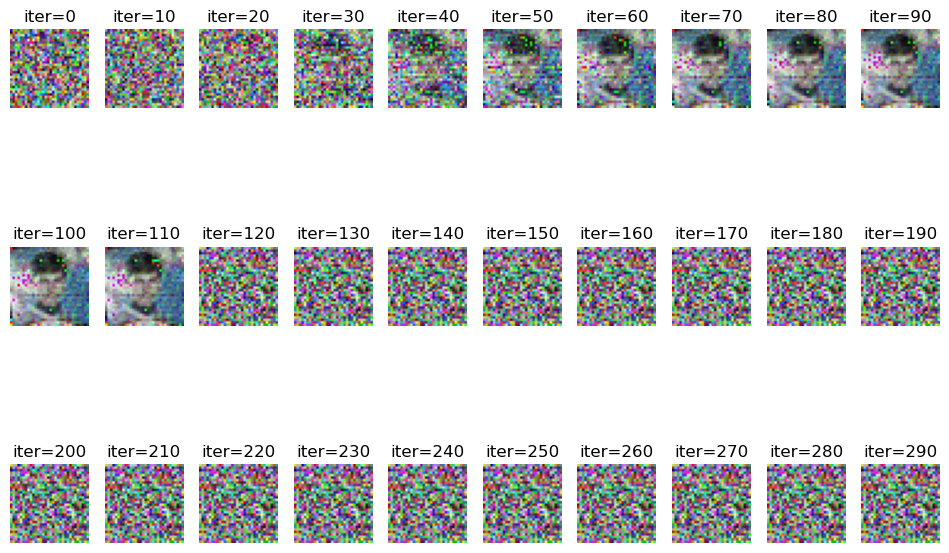

In [20]:
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i * 10])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [21]:
from skimage.metrics import peak_signal_noise_ratio as psnr
psnr(np.array(dst[img_index][0]), np.array(history[-1]))

ValueError: Input images must have the same dimensions.

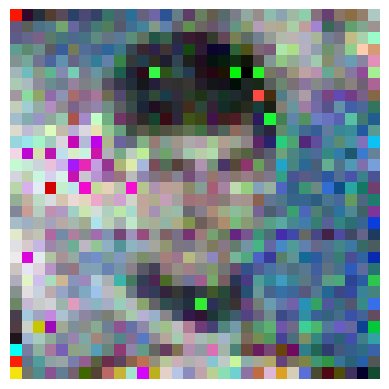

In [27]:
plt.imshow(history[100])
plt.axis('off')
plt.savefig('image_GC_{}.png'.format(100), bbox_inches='tight')

In [ ]:
# # 导入必要的库
# from skimage.metrics import structural_similarity as ssim # 使用skimage库中的SSIM函数
# import numpy as np # 使用numpy库进行数组操作

# # 定义SSIM计算函数
# def compare_ssim(img1, img2, maxvalue=255):
#     # 将图像转换为浮点数类型
#     img1 = np.array(img1).astype(np.float64)
#     img2 = np.array(img2).astype(np.float64)
#     # 调用skimage库中的SSIM函数，指定数据范围为maxvalue
#     return ssim(img1, img2, data_range=maxvalue,win_size=3)

In [ ]:
# compare_ssim(dst[img_index][0], history[-1], maxvalue=255)

In [ ]:
plt.imshow(history[i * 10])